# **OpenPyTEA** Walkthrough

## 🧭 Overview

This walkthrough demonstrates the full workflow of **OpenPyTEA**, an open-source Python toolkit for transparent and reproducible **techno-economic assessment (TEA)** of process and energy systems.

You will learn how to:

1. Define process equipment and estimate their costs.
2. Assemble a plant configuration and calculate capital and operating expenses.
3. Evaluate economic performance metrics such as **NPV**, **IRR**, **payback period**, and **levelized cost (LCOP)**.
4. Perform **sensitivity** and **uncertainty analyses** using tornado and Monte Carlo plots.
5. Visualize results and interpret TEA outputs for decision-making and design improvement.

This notebook is designed for both **researchers** and **students**, offering a clear, hands-on introduction to techno-economic modeling in Python.

## ⚙️ Setup & Imports

Before starting, ensure that **OpenPyTEA** and its dependencies are installed:

```bash
git clone https://github.com/pbtamarona/OpenPyTEA.git
cd OpenPyTEA
python -m venv env
source env/bin/activate       # Linux / macOS
env\Scripts\activate          # Windows
pip install -r docs/requirements.txt
```

Import the main modules used throughout this walkthrough:

In [1]:
# Core modules
from equipment import Equipment
from plant import Plant
from analysis import tornado_plot, monte_carlo

The following modules will be used:

| Module | Description |
|---------|--------------|
| `equipment` | Defines individual process units and calculates equipment costs. |
| `plant` | Combines equipment objects into a full plant configuration for TEA. |
| `analysis` | Provides tools for sensitivity and uncertainty analyses. |

Once the imports complete successfully, you’re ready to define your process equipment.

## 🧱 Define Equipment

Each process unit (e.g., compressor, heat exchanger, reactor) is represented by an `Equipment` object.  
You can specify the **equipment type**, **sizing variable**, **material**, and optionally provide custom cost data or scaling factors.

The equipment module automatically:
1. Selects the appropriate cost correlation from the internal database.
2. Estimates the purchased and direct costs.
3. Adjusts costs for inflation using CEPCI data.
4. Stores all technical and economic attributes for plant-level aggregation.

The direct costs refer to those incurred during the construction of a plant (installed costs), in addition to the purchased (delivered) cost of equipment, such as:
1. Equipment erection, including foundations and minor structural work
2. Piping, including insulation and painting
3. Electrical, power, and lighting
4. Instruments and automatic process control (APC) systems
5. Process buildings and structures
6. Ancillary buildings, offices, laboratory buildings, and workshops (if not costed separately as offsites)
7. Storage for raw materials and finished product (if not costed separately as offsites)
8. Utilities and provision of plant for steam, water, air, and firefighting services (if not costed separately as offsites)
9. Site preparation

Here are the mandatory and optional input for `Equipment` objects: 

| **Input Parameter**          | **Description**                                                                                                                                                           | **Example**                                               |
| ---------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------- |
| `name`                       | User-defined name or tag for the equipment instance.                                                                                                                      | `"Reactor R-101"`, `"Pump P-201"`                         |
| `param`                      | Primary sizing or design variable used in cost correlations (e.g., volume, area, or flow rate). Units depend on the equipment type (check `data\cost_correlations.csv` for this).                                       | `50` (m³), `800` (m²), or `5000` (kW)                     |
| `process_type`               | Type of process handled by the equipment, which determines installation and auxiliary cost factors. Must be one of: `"Solids"`, `"Fluids"`, `"Mixed"`, or `"Electrical"`. | `"Fluids"`                                                |
| `category`                   | Equipment category. Must match the `category` field in `data\cost_correlations.csv`.                                                                                           | `"Pump"`, `"Heat Exchanger"`, `"Compressor"`, `"Reactor"` |
| `type` *(optional)*          | Equipment sub-type. Must match the `type` field (if available) in `data\cost_correlations.csv`.                                                                                | `"Centrifugal"`, `"Shell-and-tube"`                       |
| `material` *(optional)*      | Material of construction. Affects installation cost via material multipliers. Defaults to `"Carbon steel"`.                                                               | `"316 stainless steel"`, `"Aluminum"`, `"Monel"`          |
| `num_units` *(optional)*     | Number of identical units. Automatically determined if capacity exceeds the upper limit in the correlation.                                                               | `2`                                                       |
| `purchase_cost` *(optional)* | Manually override the calculated purchase cost. If provided, the correlation and `param` are ignored.                                                                     | `1.5e6`                                                   |
| `cost_func` *(optional)*     | Explicitly specify a correlation key from `data\cost_correlations.csv` to override automatic category/type lookup.                                                             | `"HX_shell_tube_01"`                                      |
| `target_year` *(optional)*   | Target year for inflation adjustment. Defaults to `2023`.                                                                                                                 | `2025`                                                    |

Multiple equipment objects can be defined and later combined into a complete process plant using the `ProcessPlant` class (next section).

### Equipment Class – Usage Examples

Below are practical examples demonstrating all key functionalities of the `Equipment` class.

**1. Automatic Correlation Lookup**

Uses `category` and `type` to fetch cost correlations automatically and apply CEPCI inflation.

In [2]:
hx = Equipment(
    name="HX-101",
    param=850,                      # e.g., m² area
    process_type="Fluids",
    category="Heat Exchangers",
    type="U-tube shell & tube",
    material="316 stainless steel"
)

print(hx)

# To fetch the purchase and direct installation costs you can use:
print(hx.purchased_cost)
print(hx.direct_cost)

Name=HX-101, Category=Heat Exchangers, Sub-type=U-tube shell & tube, Material=316 stainless steel, Process Type=Fluids, Parameter=850, Number of units=1, Purchased Cost=297882.51705826574, Direct Cost=1114080.613797914)
297882.51705826574
1114080.613797914


**2. Using an Explicit `cost_func` Key**

Bypass automatic lookup and use a known cost-correlation key directly.

In [3]:
comp1 = Equipment(
    name='Comp-1', 
    process_type='Fluids', 
    material='Carbon steel', 
    param=150/1000, # MW
    category='Compressors & Blowers', 
    type='Compressor, centrifugal',
    cost_func = 'co2_compressor_manzolini_2011'
)

print(comp1)

Name=Comp-1, Category=Compressors & Blowers, Sub-type=Compressor, centrifugal, Material=Carbon steel, Process Type=Fluids, Parameter=0.15, Number of units=1, Purchased Cost=951318.2295706274, Direct Cost=3044218.334626008)


**3. Manually Defined `purchased_cost`**

Skip correlation and inflation calculations by supplying your own purchased cost.

In [4]:
dryer = Equipment(
    name="Rotary Dryer D-301",
    param=0,                        # ignored
    process_type="Solids",
    category="Dryer",
    material="Carbon steel",
    purchased_cost=1_500_000,        # already in target-year money
    target_year=2025
)
print(dryer)

Name=Rotary Dryer D-301, Category=Dryer, Sub-type=None, Material=Carbon steel, Process Type=Solids, Parameter=None, Number of units=1, Purchased Cost=1500000, Direct Cost=3750000.0)


**4. Auto-Parallelization for Oversized Equipment**

If `param` exceeds the upper bound in the correlation, the system automatically creates multiple parallel units.

In [5]:
comp2 = Equipment(
    name="Air Compressor C-101",
    param=90_000,                   # exceeds upper_parallel → auto-splits
    process_type="Fluids",
    category='Compressors & Blowers', 
    type='Compressor, centrifugal',
)
print(comp2)
print(comp2.num_units)

Name=Air Compressor C-101, Category=Compressors & Blowers, Sub-type=Compressor, centrifugal, Material=Carbon steel, Process Type=Fluids, Parameter=90000, Number of units=3, Purchased Cost=44889583.28584174, Direct Cost=143646666.5146936)
3


 **5. Inflation Adjustment to a Custom Year**

Calculate cost for a different inflation-adjusted year using CEPCI.

In [6]:
hx_2020 = Equipment(
    name="HX E-102",
    param=850,
    process_type="Fluids",
    category="Heat Exchangers",
    type="U-tube shell & tube",
    material="316 stainless steel",
    target_year=2020
)
print(hx_2020)

Name=HX E-102, Category=Heat Exchangers, Sub-type=U-tube shell & tube, Material=316 stainless steel, Process Type=Fluids, Parameter=850, Number of units=1, Purchased Cost=221775.1706670056, Direct Cost=829439.138294601)


**6. Effect of Material and Process Type on Direct Cost**

Demonstrates how material and process factors modify the direct (installed) cost.

In [7]:
mixer_cs = Equipment(
    name="Agitator M-101 (CS)",
    param=100,
    process_type="Fluids",
    category="Agitators & mixers",
    type="Propeller mixer",
    material="Carbon steel"
)
print(mixer_cs)

mixer_alloy = Equipment(
    name="Agitator M-102 (Alloy)",
    param=10,
    process_type="Fluids",
    category="Agitators & mixers",
    type="Propeller mixer",
    material="Hastelloy C"
)
print(mixer_alloy)

mixer_solids = Equipment(
    name="Agitator M-101 (Mixed)",
    param=100,
    process_type="Solids",
    category="Agitators & mixers",
    type="Propeller mixer",
    material="Carbon steel"
)
print(mixer_solids)

Name=Agitator M-101 (CS), Category=Agitators & mixers, Sub-type=Propeller mixer, Material=Carbon steel, Process Type=Fluids, Parameter=100, Number of units=2, Purchased Cost=249214.4300170991, Direct Cost=797486.1760547172)
Name=Agitator M-102 (Alloy), Category=Agitators & mixers, Sub-type=Propeller mixer, Material=Hastelloy C, Process Type=Fluids, Parameter=10, Number of units=1, Purchased Cost=43149.5821962902, Direct Cost=180796.74940245596)
Name=Agitator M-101 (Mixed), Category=Agitators & mixers, Sub-type=Propeller mixer, Material=Carbon steel, Process Type=Solids, Parameter=100, Number of units=2, Purchased Cost=249214.4300170991, Direct Cost=623036.0750427478)


**7. Forcing a Specific Number of Units**

Override the automatically calculated number of parallel units.

In [8]:
fridge = Equipment(
    name="Refrigerator R-201",
    param=180,
    process_type="Fluids",
    category="Utilities",
    type="Packaged mechanical refrigerator",
    num_units=3                    # manually fix number of units
)
print(fridge)

Name=Refrigerator R-201, Category=Utilities, Sub-type=Packaged mechanical refrigerator, Material=Carbon steel, Process Type=Fluids, Parameter=180, Number of units=3, Purchased Cost=579826.6516813494, Direct Cost=1855445.285380318)


## 🏭 Creating the Plant

`Plant` aggregates equipment and economics to estimate:
- **ISBL / OSBL / D&E / Contingency** → Fixed Capital using process-type multipliers and optional capital factor
- **Variable OPEX** from your itemized consumptions and prices.
- **Fixed OPEX** (labor model, supervision, overheads, maintenance, taxes/insurance, etc.) with an optional OPEX factor
- **Cash flow, NPV, LCOP, Payback, ROI, IRR** over the project lifetime, using your product price, utilization, tax, and discount rate(s)

Internally it also applies location factors by country/region and counts operators from equipment composition (fluids/solids/mixed).

### Creating a plant


In [9]:
config = {
    "plant_name": "Demo Plant",
    "process_type": "Fluids",           # "Solids" | "Fluids" | "Mixed"
    "country": "United States",
    "region": "Gulf Coast",
    "equipment": [hx, comp1, comp2],    # list of Equipment (each has .direct_cost)
    "variable_opex_inputs": {           # annualized inside the class
        "electricity":   {"consumption": 2.2e6, # daily consumption
                          "price": 0.08},       # price in USD, make sure the units match with consumption
        "cooling_water": {"consumption": 1.6e6, "price": 0.0007},
        "steam":         {"consumption": 4.0e5, "price": 0.02},
    },
    "working_capital": None,            # if None → 15% of fixed capital
    "interest_rate": 0.10,              # discount rate and WC interest
    "operator_hourly_rate": 42.0,
    "project_lifetime": 20,             # years (int ≥ 3)
    "daily_prod": 100_000,              # units/day (nameplate)
    "plant_utilization": 0.90,          # 0-1
    "product_price": 5,                 # $/unit
    "tax_rate": 0.25,
    # Depreciation (optional; defaults to straight-line if omitted)
    "depreciation": {
        "method": "macrs",            # "straight_line" | "declining_balance" | "macrs"
        "macrs_class": 7,             # 3,5,7,10,15,20 (half-year convention)
        "service_start_year": 2       # first operating year in your ramp (0/0/40%/80%/100%)
    }
}

demo_plant = Plant(config)

Update any setting later without rebuilding: `plant.update_configuration(config)`. Nested dicts (like `variable_opex_inputs`) are merged, not overwritten.

### What you can configure (keys in the config)

**Configuration Keys (Plant Object)**

| **Key**                                            | **Type / Allowed Values**           | **Description**                                                                                              |
| -------------------------------------------------- | ----------------------------------- | ------------------------------------------------------------------------------------------------------------ |
| `plant_name`                                       | `str`                               | Label for reporting and output tables.                                                                       |
| `process_type`                                     | `"Solids"` | `"Fluids"` | `"Mixed"` | Determines OSBL, D&E, and contingency factors used in fixed capital estimation.                              |
| `country`, `region`                                | `str`                               | Location factor lookup. `region` is required when the selected `country` includes multiple region factors.   |
| `equipment`                                        | `list[Equipment]`                   | Each `Equipment` object must have a `direct_cost` attribute (computed automatically or provided).            |
| `variable_opex_inputs`                             | `dict`                              | Dictionary of `{item: {consumption, price}}`; each entry is annualized within `calculate_fixed_opex()`.      |
| `working_capital`                                  | `float` or `None`                   | If omitted, defaults to **15%** of fixed capital. Interest on working capital is charged at `interest_rate`. |
| `interest_rate`                                    | `float`                             | Used for **NPV discounting** and for calculating **working capital interest**.                               |
| `operator_hourly_rate`                             | `float`                             | Hourly rate used to estimate **operating labor cost**.                                                       |
| `project_lifetime`                                 | `int` ≥ 3                           | Analysis horizon in years. Validation ensures values ≥ 3.                                                    |
| `daily_prod`, `plant_utilization`, `product_price` | `float`                             | Define annual production rate (`daily_prod × 365 × utilization`) and revenue (`× product_price`).            |
| `tax_rate`                                         | `float`                             | Corporate income tax fraction used to compute annual tax payments.                                           |

**Depreciation Configuration (optional)**

| **Key**              | **Type / Allowed Values**                             | **Description**                                                                                                                             | **Applies To**                    |
| -------------------- | ----------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------- |
| `method`             | `"straight_line"` / `"declining_balance"` / `"macrs"` | Selects the depreciation model. Defaults to `"straight_line"` if omitted.                                                                   | All methods                       |
| `life`               | `int`                                                 | Service life in years used for straight-line or declining-balance depreciation.                                                             | Straight-line / Declining-balance |
| `salvage_fraction`   | `float` (0–1)                                         | Fraction of asset value remaining at end of life (not depreciated). Defaults to 0.0 if not provided.                                        | Straight-line / Declining-balance |
| `db_factor`          | `float`                                               | Declining-balance factor (e.g., 2.0 for 200% DDB or 1.5 for 150% DB). The method automatically switches to straight-line when advantageous. | Declining-balance                 |
| `macrs_class`        | `int` ∈ {3, 5, 7, 10, 15, 20}                         | MACRS recovery period (in years) following IRS half-year convention. Determines built-in depreciation schedule.                             | MACRS                             |
| `convention`         | `"half_year"` *(default)*                             | Convention for MACRS depreciation timing. Currently only `"half_year"` is implemented.                                                      | MACRS                             |
| `service_start_year` | `int` ≥ 0                                             | Year (relative to the CAPEX ramp) when depreciation begins. Commonly set to **2**, i.e., first operating year.                              | All methods                       |

### How cost are computed

**1. Fixed Capital Investment**

The total fixed capital investment (FCI) of the plant consists of:
- Inside Battery Limits (ISBL)  
- Outside Battery Limits (OSBL)  
- Design and engineering costs (D&E)
- Contingency

Estimated using the following equation:
$$
\text{FCI} = \text{ISBL} \cdot (1 + OS) \cdot (1 + D\&E + X) \cdot LF
$$
<p style="text-align: justify;">Where, ISBL is the total of equipment direct costs and the other are factors are determined based on the user inputs in the plant configuration: <code>process_type</code>, <code>country</code>, and <code>region</code>.</p>

- **Process type**: Determines the nature of the plant's operation and influences cost estimation factors. The available types are:  
    - `Solids`: OS = 0.4, D\&E = 0.2, X = 0.1  
    - `Fluids`: OS = 0.3, D\&E = 0.3, X = 0.1  
    - `Mixed`: OS = 0.4, D\&E = 0.25, X = 0.1  

- **Country & region**: Determines the location factor (_LF_), which adjusts the estimated capital cost to reflect local economic conditions and construction costs. Available countries and regions are:  

    - **United States**
        - Gulf Coast: 1.00  
        - East Coast: 1.04  
        - West Coast: 1.07  
        - Midwest: 1.02  
    - **Canada** 
        - Ontario: 1.00  
        - Fort McMurray: 1.60  
    - **Mexico**: 1.03  
    - **Brazil**: 1.14  
    - **China**  
        - Imported: 1.12  
        - Indigenous: 0.61  
    - **Japan**: 1.26  
    - **Southeast Asia**: 1.12  
    - **Australia**: 1.21  
    - **India**: 1.02  
    - **Middle East**: 1.07  
    - **France**: 1.13  
    - **Germany**: 1.11  
    - **Italy**: 1.14  
    - **Netherlands**: 1.19  
    - **Russia**: 1.53  
    - **United Kingdom**: 1.02  

*Note: These factors are based on _Chemical Engineering Design_, 3rd Edition (Towler & Sinnott, 2021).*

Call to calculate FCI:

In [10]:
demo_plant.calculate_fixed_capital(fc=1.05, print_results=True)


Capital cost estimation
ISBL: $155,195,213.74
OSBL: $46,558,564.12
Design and engineering: $60,526,133.36
Contingency: $20,175,377.79
Fixed capital investment: $282,455,289.00


If you need only the ISBL, you can just perform `calculate_isbl`:

In [11]:
demo_plant.calculate_isbl(print_results=True)

ISBL cost estimation: $147,804,965.46


To retrieve the values of cost estimates for each component of capital cost, you can simply access the corresponding attributes:

In [12]:
print(f"OSBL: ${demo_plant.osbl:,.2f}")
print(f'Design and Engineering: ${demo_plant.dne:,.2f}')
#  ... and so on

OSBL: $46,558,564.12
Design and Engineering: $60,526,133.36


**2. Fixed Operating Expenditure**

Fixed production costs are those costs that do not vary with the rate of production, these include:
- Maintenance
- Taxes and insurance
- Operating labor
- Supervision and overhead
- et cetera.

<p style="text-align: justify;">Fixed production costs are calculated using the <code>calculate_fixed_opex</code> function of the <code>ProcessPlant</code> object. Most cost components are derived from multiplication factors reported in <i>Analysis, Synthesis, and Design of Chemical Processes</i>, 5th Edition (Turton et al., 2018). These factors are applied to estimate fixed cost components based on the plant’s fixed capital investment, working capital, variable production costs, interest rate, and operator hourly rate. Thus, here, we first need to pass our working capital, interest rate and operator hourly rate assumptions to out <code>ProcessPlant</code> object:</p>

Call to calculate Fixed OPEX:

In [13]:
demo_plant.calculate_fixed_opex(print_results=True)  # Calculate fixed OPEX costs

Fixed production costs estimation
Operating labor costs: $1,070,160.00 per year
Supervision costs: $267,540.00 per year
Direct salary overhead: $668,850.00 per year
Laboratory charges: $107,016.00 per year
Maintenance costs: $7,759,760.69 per year
Taxes and insurance costs: $2,327,928.21 per year
Rent of land costs: $3,026,306.67 per year
Environmental charges: $2,017,537.78 per year
Operating supplies: $1,396,756.92 per year
General plant overhead: $1,304,257.50 per year
Interest on working capital: $4,236,829.34 per year
Patents and royalties: $1,827,846.52 per year
Distribution and selling costs: $1,827,846.52 per year
R&D costs: $2,741,769.78 per year
Fixed OPEX: $30,580,405.91 per year


To retrieve the values for each fixed operating cost components, you can do:

In [14]:
print(f'Operating labor costs: ${demo_plant.operating_labor_costs:,.2f}')
print(f'Supervision costs: ${demo_plant.supervision_costs:,.2f}')
print(f'Maintenance costs: ${demo_plant.maintenance_costs:,.2f}')
# ..... and so on

Operating labor costs: $1,070,160.00
Supervision costs: $267,540.00
Maintenance costs: $7,759,760.69


**3. Variable Operating Expenditure**

Variable operating expenses represent consumables and utilities that scale directly with plant production.
These are defined through the variable_opex_inputs dictionary in your plant configuration and are automatically processed inside calculate_variable_opex().

Each entry in variable_opex_inputs follows the format:
```python
"variable_opex_inputs": {
    "<item_name>": {
        "consumption": <annual_quantity>,
        "price": <unit_price>
    },
    ...
}
```

During calculation:
1. Each item’s annual cost is computed as:

            cost = daily_consumption × price × 365 x plant_utilization

2. All items are summed to form the total variable operating cost (`self.variable_production_costs`).

3. The results are stored in the plant instance and can be printed when `print_results=True.`

For example:

In [15]:
config = {
    "variable_opex_inputs": {
        "electricity":   {"consumption": 1.1e6, "price": 0.05},
        "cooling_water": {"consumption": 1.6e6, "price": 0.0007},
        "steam":         {"consumption": 4.0e5, "price": 0.02},
        "natural_gas":   {"consumption": 1.0e5, "price": 0.035}
    },
}

demo_plant.update_configuration(config)

Then run:

In [16]:
demo_plant.calculate_variable_opex(print_results=True)

Variable production costs estimation
  - Electricity: $18,067,500.00 per year
  - Cooling water: $367,920.00 per year
  - Steam: $2,628,000.00 per year
  - Natural gas: $1,149,750.00 per year
Total Variable OPEX: $22,213,170.00 per year


**4. Cash Flow Calculation**

The cash flow represents the net annual financial performance of the plant, combining revenues, operating costs, capital investments, taxes, and depreciation.
It is generated by calling:

In [17]:
demo_plant.calculate_cash_flow(print_results=True)

,Year,Capital cost,Revenue,Cash cost,Gross profit,Depreciation,Taxable income,Tax paid,Cash flow
0,1,"$84,736,586.70",$0.00,"$27,675,123.65","$-27,675,123.65",$0.00,"$-27,675,123.65",$0.00,"$-112,411,710.35"
1,2,"$169,473,173.40",$0.00,"$27,675,123.65","$-27,675,123.65",$0.00,"$-27,675,123.65",$0.00,"$-197,148,297.05"
2,3,"$70,613,822.25","$65,700,000.00","$36,560,391.65","$29,139,608.35","$40,362,860.80","$-11,223,252.45",$0.00,"$-41,474,213.90"
3,4,$0.00,"$131,400,000.00","$45,445,659.65","$85,954,340.35","$69,173,300.28","$16,781,040.07",$0.00,"$85,954,340.35"
4,5,$0.00,"$164,250,000.00","$49,888,293.65","$114,361,706.35","$49,401,430.05","$64,960,276.30","$4,195,260.02","$110,166,446.33"
5,6,$0.00,"$164,250,000.00","$49,888,293.65","$114,361,706.35","$35,278,665.60","$79,083,040.75","$16,240,069.08","$98,121,637.27"
6,7,$0.00,"$164,250,000.00","$49,888,293.65","$114,361,706.35","$25,223,257.31","$89,138,449.04","$19,770,760.19","$94,590,946.16"
7,8,$0.00,"$164,250,000.00","$49,888,293.65","$114,361,706.35","$25,195,011.78","$89,166,694.57","$22,284,612.26","$92,077,094.09"
8,9,$0.00,"$164,250,000.00","$49,888,293.65","$114,361,706.35","$25,223,257.31","$89,138,449.04","$22,291,673.64","$92,070,032.70"
9,10,$0.00,"$164,250,000.00","$49,888,293.65","$114,361,706.35","$12,597,505.89","$101,764,200.46","$22,284,612.26","$92,077,094.09"


The method builds yearly arrays for capital cost, production, revenue, OPEX, depreciation, taxable income, and cash flow over the defined project lifetime.

---
**Capital Expenditure (CAPEX) Ramp**

Capital spending occurs during the first three years according to:

| **Year**   | **CAPEX Fraction** | **Description**                              |
| ---------- | ------------------ | -------------------------------------------- |
| 0          | 30%                | Initial design and early construction        |
| 1          | 60%                | Major equipment procurement and installation |
| 2          | 10%                | Commissioning and start-up costs             |
| Final year | —                  | Working capital released (negative CAPEX)    |

Working capital is drawn in year 2 and returned in the final year.

---
**Production Ramp**

Plant output increases gradually to reach full capacity:

| **Year** | **Production Level** |
| -------- | -------------------- |
| 0        | 0%                   |
| 1        | 0%                   |
| 2        | 40%                  |
| 3        | 80%                  |
| 4+       | 100% (steady state)  |

Full annual production is calculated as:

            Annual Production = daily_prod × 365 × plant_utilization × ramp_factor

The CAPEX and Production Ramp are currently not modifiable.

---
**Revenue and Operating Costs**

Revenue for each year is calculated as:

            Revenue = product_price × Annual Production

Operating costs include:
- Variable OPEX (from utilities and consumables)
- Fixed OPEX (labor, maintenance, overheads, WC interest, etc.)
- Adjusted by ramp factor during the start-up years

---
**Depreciation**

Depreciation is applied using the selected depreciation method
(`straight_line`, `declining_balance`, or `macrs`) and begins in the configured `service_start_year`.

You can change the depreciation method as follows: 

In [18]:
# Switching to straight-line depreciation
demo_plant.update_configuration({
    "depreciation": {
        "method": "straight_line",
        "life": 12,
        "salvage_fraction": 0.05,
        "service_start_year": 2
    }
})

demo_plant.calculate_cash_flow(print_results=True)

,Year,Capital cost,Revenue,Cash cost,Gross profit,Depreciation,Taxable income,Tax paid,Cash flow
0,1,"$84,736,586.70",$0.00,"$27,675,123.65","$-27,675,123.65",$0.00,"$-27,675,123.65",$0.00,"$-112,411,710.35"
1,2,"$169,473,173.40",$0.00,"$27,675,123.65","$-27,675,123.65",$0.00,"$-27,675,123.65",$0.00,"$-197,148,297.05"
2,3,"$70,613,822.25","$65,700,000.00","$36,560,391.65","$29,139,608.35","$22,361,043.71","$6,778,564.63",$0.00,"$-41,474,213.90"
3,4,$0.00,"$131,400,000.00","$45,445,659.65","$85,954,340.35","$22,361,043.71","$63,593,296.63","$1,694,641.16","$84,259,699.19"
4,5,$0.00,"$164,250,000.00","$49,888,293.65","$114,361,706.35","$22,361,043.71","$92,000,662.63","$15,898,324.16","$98,463,382.19"
5,6,$0.00,"$164,250,000.00","$49,888,293.65","$114,361,706.35","$22,361,043.71","$92,000,662.63","$23,000,165.66","$91,361,540.69"
6,7,$0.00,"$164,250,000.00","$49,888,293.65","$114,361,706.35","$22,361,043.71","$92,000,662.63","$23,000,165.66","$91,361,540.69"
7,8,$0.00,"$164,250,000.00","$49,888,293.65","$114,361,706.35","$22,361,043.71","$92,000,662.63","$23,000,165.66","$91,361,540.69"
8,9,$0.00,"$164,250,000.00","$49,888,293.65","$114,361,706.35","$22,361,043.71","$92,000,662.63","$23,000,165.66","$91,361,540.69"
9,10,$0.00,"$164,250,000.00","$49,888,293.65","$114,361,706.35","$22,361,043.71","$92,000,662.63","$23,000,165.66","$91,361,540.69"


In [19]:
# Switching to Declining-Balance (200% DDB)
demo_plant.update_configuration({
    "depreciation": {
        "method": "declining_balance",
        "life": 10,
        "db_factor": 2.0,        # 200% DDB (use 1.5 for 150% DB)
        "salvage_fraction": 0.1,
        "service_start_year": 2
    }
})

demo_plant.calculate_cash_flow(print_results=True)

,Year,Capital cost,Revenue,Cash cost,Gross profit,Depreciation,Taxable income,Tax paid,Cash flow
0,1,"$84,736,586.70",$0.00,"$27,675,123.65","$-27,675,123.65",$0.00,"$-27,675,123.65",$0.00,"$-112,411,710.35"
1,2,"$169,473,173.40",$0.00,"$27,675,123.65","$-27,675,123.65",$0.00,"$-27,675,123.65",$0.00,"$-197,148,297.05"
2,3,"$70,613,822.25","$65,700,000.00","$36,560,391.65","$29,139,608.35","$56,491,057.80","$-27,351,449.45",$0.00,"$-41,474,213.90"
3,4,$0.00,"$131,400,000.00","$45,445,659.65","$85,954,340.35","$45,192,846.24","$40,761,494.11",$0.00,"$85,954,340.35"
4,5,$0.00,"$164,250,000.00","$49,888,293.65","$114,361,706.35","$36,154,276.99","$78,207,429.35","$10,190,373.53","$104,171,332.82"
5,6,$0.00,"$164,250,000.00","$49,888,293.65","$114,361,706.35","$28,923,421.59","$85,438,284.75","$19,551,857.34","$94,809,849.01"
6,7,$0.00,"$164,250,000.00","$49,888,293.65","$114,361,706.35","$23,138,737.27","$91,222,969.07","$21,359,571.19","$93,002,135.16"
7,8,$0.00,"$164,250,000.00","$49,888,293.65","$114,361,706.35","$18,510,989.82","$95,850,716.53","$22,805,742.27","$91,555,964.08"
8,9,$0.00,"$164,250,000.00","$49,888,293.65","$114,361,706.35","$14,808,791.86","$99,552,914.49","$23,962,679.13","$90,399,027.21"
9,10,$0.00,"$164,250,000.00","$49,888,293.65","$114,361,706.35","$11,847,033.48","$102,514,672.86","$24,888,228.62","$89,473,477.72"


---

**Tax**

Taxable income is computed as:

            Taxable Income = Gross Profit − Depreciation


A *one-year lag* is applied to taxation:

taxes in year t are based on taxable income from year t−1.

---

**Cash Flow Formula**

The annual cash flow for each year is calculated as:

        Cash Flow = Gross Profit − Tax Paid − Capital Cost

where:
- Gross Profit = Revenue − (Fixed OPEX + Variable OPEX)
- Tax Paid = tax_rate × previous_year_taxable_income
- Capital Cost includes CAPEX spending and working capital adjustment

Now we can use the `calculate_variable_opex` function:

To retrieve the values for each variable operating cost components, you can do:

**5. Economic Performance Metrics**

After building cash flows, use these methods to evaluate project economics.

Run them after **calculate_cash_flow()** so the yearly arrays are available.

---

**Net Present Value (NPV)**

Concept: Present value of all yearly cash flows discounted at interest_rate.

Call:

In [20]:
demo_plant.calculate_npv(print_results=True)

Year | Present Value (PV) | Cumulative NPV
-------------------------------------------
   1 | $-102,192,463.96 | $-102,192,463.96
   2 | $-162,932,476.90 | $-265,124,940.86
   3 | $ -31,160,190.76 | $-296,285,131.62
   4 | $  58,707,971.00 | $-237,577,160.62
   5 | $  64,682,201.80 | $-172,894,958.82
   6 | $  53,517,688.08 | $-119,377,270.74
   7 | $  47,724,800.67 | $ -71,652,470.07
   8 | $  42,711,532.94 | $ -28,940,937.13
   9 | $  38,338,012.14 | $   9,397,075.02
  10 | $  34,495,898.92 | $  43,892,973.93
  11 | $  31,100,388.55 | $  74,993,362.48
  12 | $  28,091,800.99 | $ 103,085,163.47
  13 | $  25,538,000.90 | $ 128,623,164.38
  14 | $  22,586,258.68 | $ 151,209,423.06
  15 | $  20,532,962.44 | $ 171,742,385.50
  16 | $  18,666,329.49 | $ 190,408,714.99
  17 | $  16,969,390.45 | $ 207,378,105.43
  18 | $  15,426,718.59 | $ 222,804,824.02
  19 | $  14,024,289.62 | $ 236,829,113.64
  20 | $  19,047,131.04 | $ 255,876,244.68


Formula:

$
\displaystyle NPV = \sum_{t=1}^{t_p} \frac{\mathrm{Cash Flow}_t}{(1 + i)^t}
$  

- $i$ = fixed interest rate  
- $t_p$ = project lifetime  (years)

Outputs:

`plant.pv_array` – present value of each year’s cash flow

`plant.npv_array` – cumulative NPV by year (final entry is project NPV)

---

**Levelized Cost of Product (LCOP)**

Concept: The break-even selling price that sets NPV = 0 over the analysis horizon, given production volumes.

Call:

In [21]:
demo_plant.calculate_levelized_cost(print_results=True)

Levelized cost: $3.132/kg


Typical computation formula:

$
\displaystyle LCOP = \frac{\sum_{t=1}^{t_p} \frac{CAPEX_t + OPEX_t}{(1 + i)^{t}}}{\sum_{t=1}^{t_p} \frac{Q_t}{(1 + i)^{t}}}
$

- $CAPEX_t$ = capital expenditure in year $t$  
- $OPEX_t$ = operating expenditure (cash cost) in year $t$  
- $Q_t$ = production output in year $t$  

Outputs:
- `plant.levelized_cost` – scalar levelized cost

---

**Payback Time (PBT)**

Concept: First year when cumulative cash flow ≥ 0 (undiscounted payback).

Call:

In [22]:
demo_plant.calculate_payback_time(print_results=True)

Payback time: 3.35 years


Formula:

$
\displaystyle \mathrm{PBT} = \frac{\mathrm{FCI}}{\overline{CF}}
$  
where:  
- $\mathrm{FCI}$ = fixed capital investment  
- $\overline{CF}$ = average annual cash flow  

Outputs:
- `plant.payback_time` – scalar PBT (years)

---

**Return on Investment (ROI)**

Concept: Ratio of average annual profit to total invested capital (definition may vary; this follows your code’s chosen approach).

Call:

In [23]:
demo_plant.calculate_roi(print_results=True)

Return of investment: 22.91%


Formula:

$
\displaystyle ROI = \frac{\sum_{t=1}^{t_p} \text{Net Profit}_t}{t_p \cdot \sum \text{Total Investment}}
$ 

where:  
- $\text{Net Profit}_t$ = plant net profit in year $t$  
- $\text{Total Investment}$ = invested capital = FCI + working capital

Outputs:
- `plant.roi` – scalar ROI (fraction)

---

**Internal Rate of Return (IRR)**

Concept: Discount rate that makes NPV = 0 for the project cash flows.

Call:

In [24]:
demo_plant.calculate_irr(print_results=True)

Internal Rate of Return: 19.98%


Equation: 

Find IRR such that,
$
\displaystyle 0 = \sum_{t=1}^{t_p} \frac{CF_t}{(1 + IRR)^{t}}
$

Outputs:
- `plant.irr` – scalar IRR (fraction)




## ⚖️ Sensitivity and Uncertainty Analyses

In techno-economic analysis (TEA), sensitivity analysis helps quantify how uncertainty in key assumptions propagates through the model to affect economic performance.
Parameters such as capital costs, utility prices, operating factors, and financial assumptions rarely remain fixed throughout a project’s life. Understanding which inputs most strongly influence the Levelized Cost of Product (LCOP) enables better risk management and investment decisions.

This section presents two complementary approaches:

### 🌀 Tornado Plot (Deterministic Sensitivity)

A one-at-a-time (OAT) sensitivity approach.
Each selected input variable is perturbed by a fixed percentage (e.g., ±50%) around its baseline value while all other parameters remain constant.
The change in LCOP is recalculated for each case, and the results are displayed in a tornado plot—a horizontal bar chart where bar length indicates the magnitude of impact.
This method highlights which parameters exert the greatest influence on the project outcome and helps prioritize data refinement or cost-reduction efforts.

You generate the tornado plot as follows:

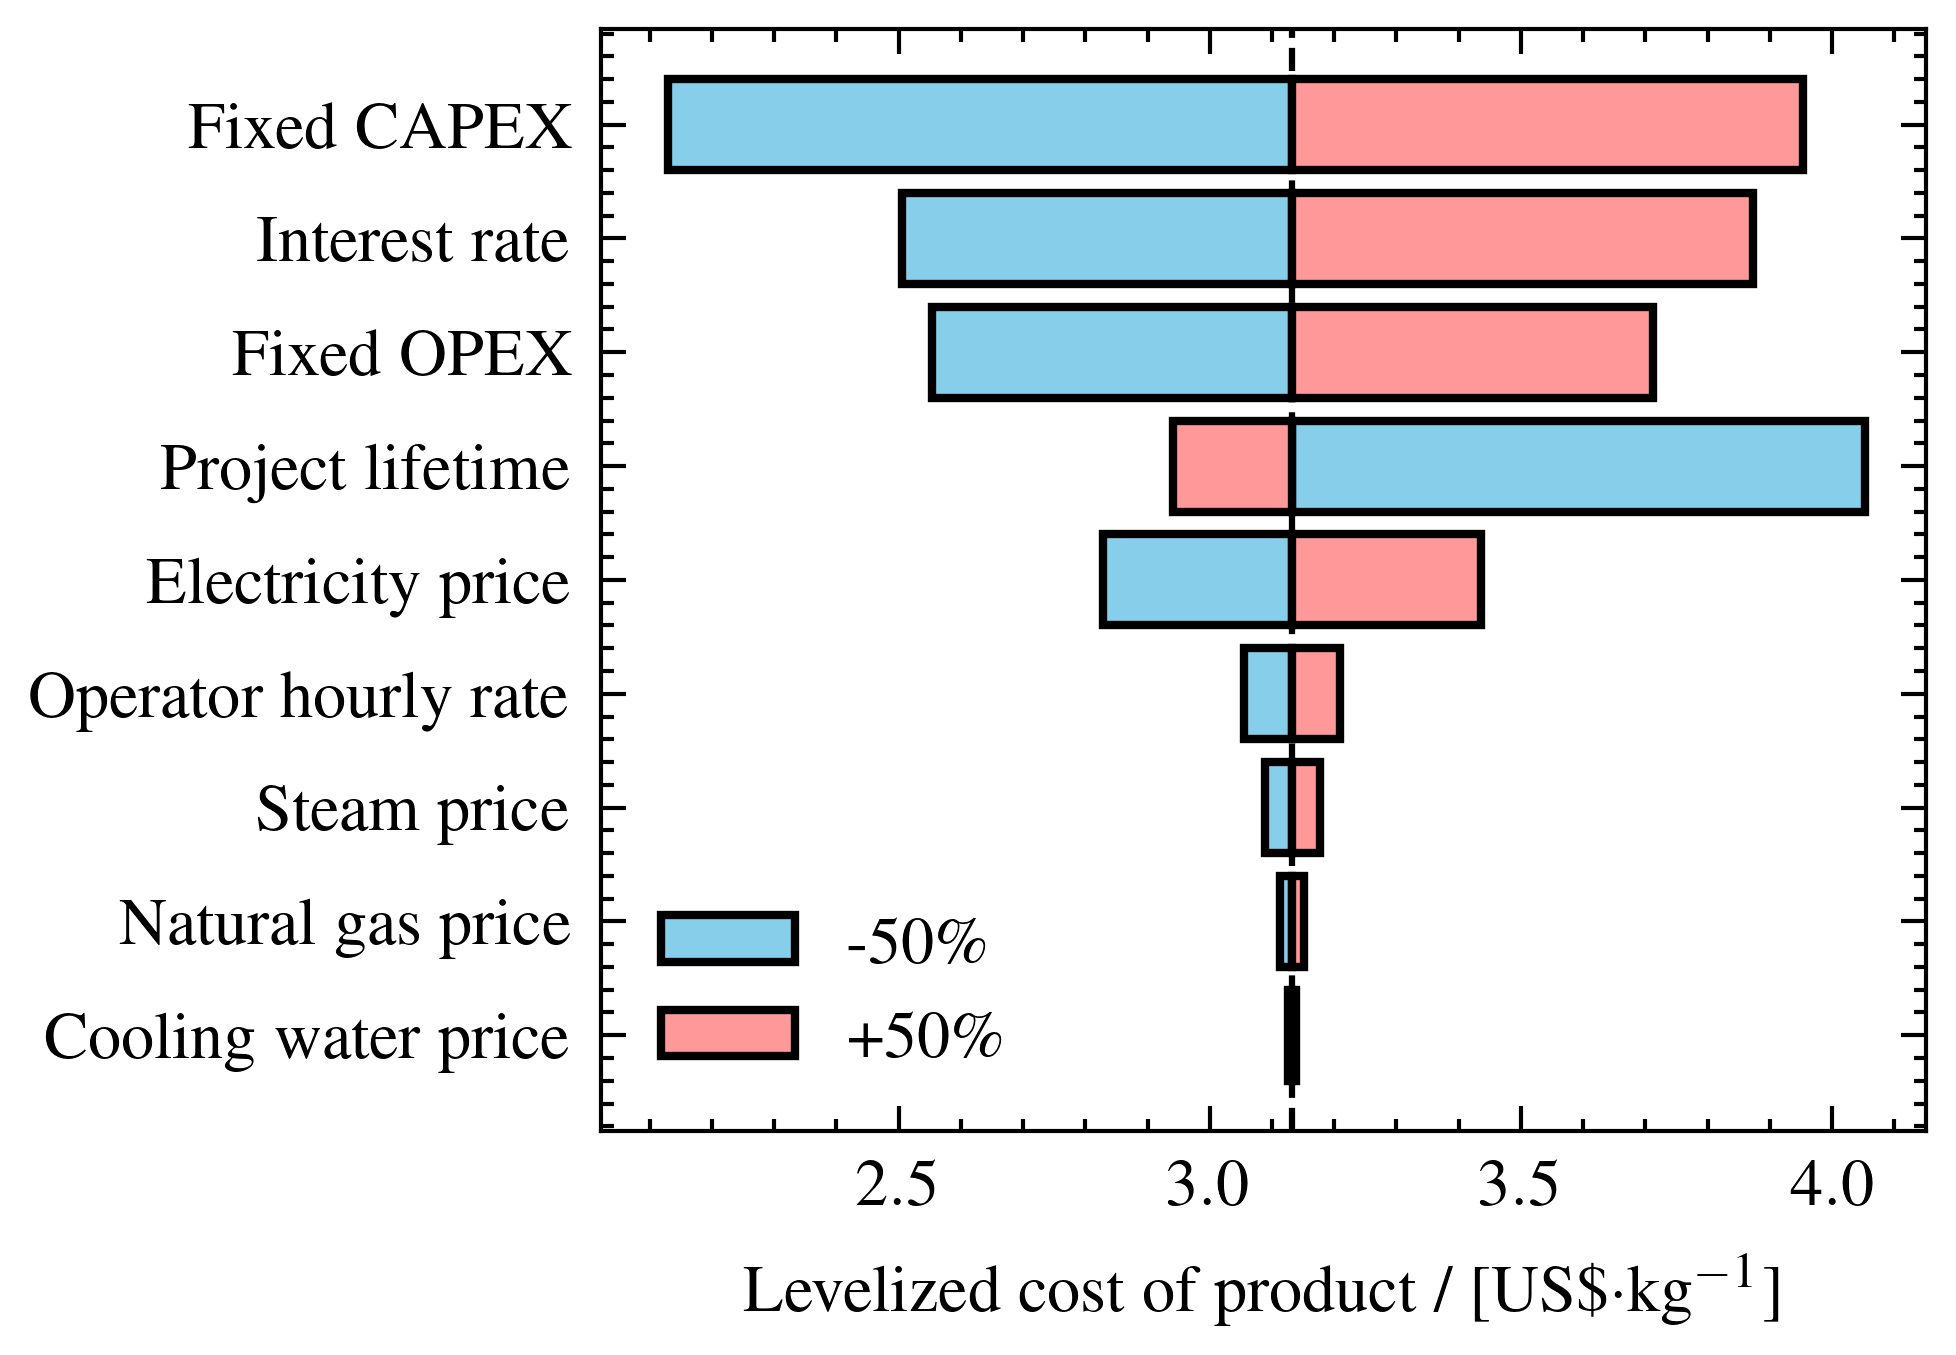

In [25]:
tornado_plot(plant = demo_plant, plus_minus_value=0.5, label=r'Levelized cost of product / [US\$$\cdot$kg$^{-1}$]')

### 🎲 Monte Carlo Simulation (Probabilistic Sensitivity)

A stochastic uncertainty analysis that captures simultaneous variation in all uncertain parameters.
Each variable is assigned a probability distribution (e.g., truncated normal), and the model is executed thousands—or even millions—of times.
Each iteration samples random values from the distributions and computes a new LCOP, resulting in a distribution of LCOP outcomes.
This allows evaluation of:
- The expected LCOP (mean or median value),
- The spread (variance or confidence intervals),
- And the likelihood of exceeding target costs or achieving economic viability.

Monte Carlo analysis therefore provides a probabilistic understanding of economic risk, complementing the deterministic insight from the tornado plot.

**Defining Variable OPEX with Uncertainty for Monte Carlo Analysis**

To perform Monte Carlo simulations, the variable operating costs must include not only the baseline prices and consumptions, but also their statistical uncertainty.
Each utility or consumable input is therefore defined with:

- `consumption` – the daily usage quantity (in consistent process units)
- `price` – the mean or baseline unit price
- `price_std` – the standard deviation around the mean, representing uncertainty
- `price_min` / `price_max` – lower and upper bounds used to truncate extreme values

This structure enables the simulation engine to draw random samples for each input price from a bounded normal distribution, ensuring that every Monte Carlo iteration reflects realistic cost variability.

In [26]:
config = {
    "variable_opex_inputs": {
        "electricity": {
            "consumption": 1.1e6,        # Daily consumption 
            "price": 0.1,               # Mean unit price
            "price_std": 0.05,           # Standard deviation (uncertainty)
            "price_min": 0.01,           # Minimum plausible price
            "price_max": 0.30            # Maximum plausible price
        },
        "cooling_water": {
            "consumption": 1.6e6,        # Daily consumption
            "price": 0.0008,             # Mean unit price 
            "price_std": 0.0003,         # Standard deviation
            "price_min": 0.0001,         # Minimum plausible price
            "price_max": 0.0014          # Maximum plausible price
        },
        "steam": {
            "consumption": 4.0e5,        # Daily consumption 
            "price": 0.04,               # Mean unit price 
            "price_std": 0.02,           # Standard deviation
            "price_min": 0.00,           # Minimum plausible price
            "price_max": 0.08            # Maximum plausible price
        },
        "natural_gas": {
            "consumption": 1.0e5,        # Daily consumption 
            "price": 0.05,              # Mean unit price 
            "price_std": 0.03,           # Standard deviation
            "price_min": 0.005,          # Minimum plausible price
            "price_max": 0.1             # Maximum plausible price
        }
        # Add more variable OPEX items as needed
    }
}

demo_plant.update_configuration(config)

**Additional Economic Uncertainties for Monte Carlo**

Besides variable OPEX, several plant-level parameters strongly affect economic results.
These can also be randomized in simulations to capture financial uncertainty:

| **Parameter**       | **Description**                                          | **Effect on Model**                                           | **Default Standard Deviation** |
| ------------------- | -------------------------------------------------------- | ------------------------------------------------------------- | ----------------------------   |
| `fixed_capitals`    | Total installed CAPEX (ISBL + OSBL + D&E + contingency). | Drives initial investment, depreciation, and working capital. | 30%                            |  
| `fixed_opexs`       | Annual fixed OPEX (labor, maintenance, overheads).       | Affects yearly cash cost.                                     | 30%                            |
| `operator_hourlys`  | Operator wage rate (USD/hr).                             | Influences labor and overhead costs.                          | $10                            |
| `project_lifetimes` | Economic project life (years).                           | Defines NPV and depreciation horizon.                         | 5 years                        |
| `interests`         | Discount or financing rate (WACC).                       | Controls discounting and LCOP.                                | 3%                             |


Currently, this is not modifiable.

The following line runs the Monte Carlo analysis with 1,000,000 millions sampling:

In [ ]:
monte_carlo(plant=demo_plant, num_samples=1_000_000, batch_size=1000, show_input_distributions=True)

If you have multiple plants, you can plot the probability distribution results in one figure. See `examples/case_study_1`.